# nanoGPT – Quick Training Notebook

Use this notebook to run a short training loop on Tiny Shakespeare (character-level).

Workflow:
1) Run "Setup" to detect device and branch.
2) Run "Prepare data" once (creates `data/shakespeare_char/train.bin`, `val.bin`).
3) Run "Train" to see losses (train/val) for a very short run.
4) If you edit `model.py`, rerun the "Reload model & Rebuild" cell to pick up changes (module reload).

Configuration:
- Small model (4 layers, 4 heads, 128 embedding dim)
- Fast training (300 iterations)
- No DDP, no `torch.compile` for simplicity



In [1]:
# Setup: imports, device, utils
from __future__ import annotations
import os
import sys
import math
import time
import subprocess
from pathlib import Path
from typing import Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt

# Ensure repository root on sys.path
repo_root = Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))


def detect_device() -> str:
    if torch.cuda.is_available():
        return 'cuda'
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'


def current_branch() -> str:
    try:
        out = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"], cwd=repo_root)
        return out.decode().strip()
    except Exception:
        return "unknown"


def checkout_branch(name: str) -> None:
    """Optionally switch branches from within the notebook, then reload model in a later cell."""
    subprocess.check_call(["git", "checkout", name], cwd=repo_root)
    print(f"Switched to branch: {name}")


device = detect_device()
torch.manual_seed(1337)
print(f"Device: {device}")
print(f"Git branch: {current_branch()}")

# Plot style
plt.style.use('ggplot')



Device: mps
Git branch: master


In [2]:
# Prepare data: Tiny Shakespeare (character-level)
from pathlib import Path
import subprocess
import sys

DATA_DIR = repo_root / "data" / "shakespeare_char"
TRAIN_BIN = DATA_DIR / "train.bin"
VAL_BIN = DATA_DIR / "val.bin"

if TRAIN_BIN.exists() and VAL_BIN.exists():
    print("Tiny Shakespeare binaries already exist.")
    print(f"- {TRAIN_BIN}")
    print(f"- {VAL_BIN}")
else:
    print("Preparing Tiny Shakespeare dataset (this downloads ~1MB and preprocesses)...")
    subprocess.check_call([sys.executable, str(DATA_DIR / "prepare.py")], cwd=repo_root)
    assert TRAIN_BIN.exists() and VAL_BIN.exists(), "Data preparation failed to produce train.bin/val.bin"
    print("Done.")



Tiny Shakespeare binaries already exist.
- /Users/darienschettler/PycharmProjects/nanoGPT-1/data/shakespeare_char/train.bin
- /Users/darienschettler/PycharmProjects/nanoGPT-1/data/shakespeare_char/val.bin


In [7]:
# Training utilities: tiny config & dataloader
import numpy as np
import torch

# Small, fast config suitable for CPU/MPS/GPU
block_size = 64
batch_size = 16
n_layer = 4
n_head = 4
n_embd = 128
dropout = 0.0
max_iters = 5000
log_interval = 10
eval_interval = 50
eval_iters = 20
learning_rate = 3e-4
weight_decay = 0.1

# Dataloader: same shape semantics as train.py
DATA_MEM_TRAIN = str(TRAIN_BIN)
DATA_MEM_VAL = str(VAL_BIN)

def get_batch(split: str) -> tuple[torch.Tensor, torch.Tensor]:
    data = np.memmap(DATA_MEM_TRAIN if split == 'train' else DATA_MEM_VAL, dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model) -> dict[str, float]:
    model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out



In [8]:
# Reload model & Rebuild (run this after switching branches or editing model.py)
import importlib
import model as model_module
importlib.reload(model_module)
from model import GPTConfig, GPT

print(f"Using model from: {model_module.__file__}")

# Infer vocab size from dataset meta if present, fallback to GPT-2 padded size
import pickle
meta_path = DATA_DIR / 'meta.pkl'
meta_vocab_size = None
if meta_path.exists():
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = int(meta.get('vocab_size', 50304))

vocab_size = meta_vocab_size if meta_vocab_size is not None else 50304

cfg = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_layer=n_layer,
    n_head=n_head,
    n_embd=n_embd,
    dropout=dropout,
    bias=True,
)
model = GPT(cfg).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print("Model built.")



Using model from: /Users/darienschettler/PycharmProjects/nanoGPT-1/model.py
number of parameters: 0.80M
Model built.


[init] train loss: 4.2131, val loss: 4.2104
iter   10 | loss 3.4298
iter   20 | loss 3.2970
iter   30 | loss 3.0820
iter   40 | loss 2.9281
iter   50 | loss 2.8289
[eval] iter   50 | train 2.8189 | val 2.8397
iter   60 | loss 2.7658
iter   70 | loss 2.6816
iter   80 | loss 2.6432
iter   90 | loss 2.6596
iter  100 | loss 2.6114
[eval] iter  100 | train 2.6455 | val 2.6430
iter  110 | loss 2.5524
iter  120 | loss 2.6348
iter  130 | loss 2.5236
iter  140 | loss 2.5778
iter  150 | loss 2.5656
[eval] iter  150 | train 2.5474 | val 2.5453
iter  160 | loss 2.5664
iter  170 | loss 2.4794
iter  180 | loss 2.5529
iter  190 | loss 2.4935
iter  200 | loss 2.5063
[eval] iter  200 | train 2.4903 | val 2.4921
iter  210 | loss 2.4349
iter  220 | loss 2.4652
iter  230 | loss 2.4623
iter  240 | loss 2.4486
iter  250 | loss 2.4650
[eval] iter  250 | train 2.4388 | val 2.4669
iter  260 | loss 2.4160
iter  270 | loss 2.3521
iter  280 | loss 2.4725
iter  290 | loss 2.4091
iter  300 | loss 2.4700
[eval] iter

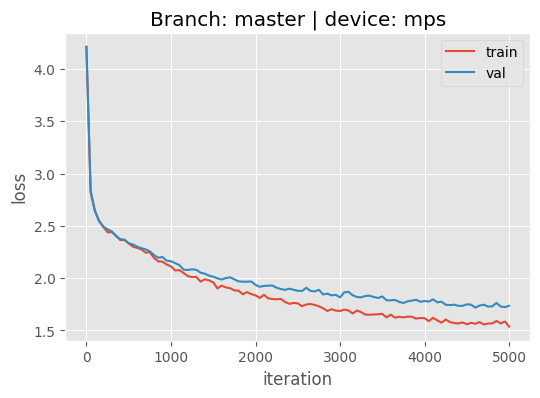

In [9]:
# Train (brief run) and plot
train_losses, val_losses, steps = [], [], []

# Initial eval
losses = estimate_loss(model)
print(f"[init] train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")
train_losses.append(losses['train'])
val_losses.append(losses['val'])
steps.append(0)

for it in range(1, max_iters + 1):
    X, Y = get_batch('train')
    logits, loss = model(X, Y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if it % log_interval == 0:
        print(f"iter {it:4d} | loss {loss.item():.4f}")

    if it % eval_interval == 0:
        losses = estimate_loss(model)
        print(f"[eval] iter {it:4d} | train {losses['train']:.4f} | val {losses['val']:.4f}")
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        steps.append(it)

# Plot
plt.figure(figsize=(6,4))
plt.plot(steps, train_losses, label='train')
plt.plot(steps, val_losses, label='val')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title(f"Branch: {current_branch()} | device: {device}")
plt.legend()
plt.show()



In [11]:
# Quick sampling helper after training
import torch
from torch.nn import functional as F

def sample(model, start: str = "To be, or", max_new_tokens: int = 100, temperature: float = 1.0) -> str:
    model.eval()
    # Load tokenizer metadata if present (char-level uses simple identity)
    # For Tiny Shakespeare char-level, meta.pkl includes 'itos' / 'stoi'
    import pickle
    meta_path = DATA_DIR / 'meta.pkl'
    if not meta_path.exists():
        print("No meta.pkl found; sampling skipped.")
        return ""
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    stoi = meta['stoi']
    itos = meta['itos']

    def encode(s: str):
        return [stoi[c] for c in s]

    def decode(ids):
        return ''.join([itos[i] for i in ids])

    idx = torch.tensor([encode(start)], dtype=torch.long, device=device)
    with torch.no_grad():
        idx = model.generate(idx, max_new_tokens=max_new_tokens, temperature=temperature)
    return decode(idx[0].tolist())

print(sample(model, start="ROMEO:", max_new_tokens=200, temperature=0.8))

ROMEO:
Thou war to this me honest to their and poor lath
The had ere ease to by son, King-corrand, now
With guest to death! him not this hornors
With chans I answer'd meanus honour to bleed
Farewell; let me
